In [ ]:
import argparse
import pandas as pd
import pickle
from scripts.imports import *
from scripts.parallel_blocks import *
from scripts.FSC_dataframe_phoreal import FSC_dataframe

# Function to parse command line arguments
def parse_args():
    parser = argparse.ArgumentParser(description="Generate and save a concatenated dataframe from multiple directories.")
    parser.add_argument('output_pickle', type=str, help='Name of the output pickle file (without extension)')
    parser.add_argument('--width', type=float, default=5, help='Width of the box (default: 0.05)')
    parser.add_argument('--height', type=float, default=5, help='Height of the box (default: 0.05)')
    parser.add_argument('--small_box', type=float, default=1, help='Size of the small box (default: 0.005)')
    parser.add_argument('--threshold', type=int, default=1, help='Data threshold value (default: 2)')
    parser.add_argument('--alt_thresh', type=int, default=80, help='Altitude threshold value (default: 90)')
    parser.add_argument('--rebinned', type=int, default=0, help='Rebinned into specified meter resolution')
    parser.add_argument('--method', type=str, default='normal', help='Method for probability distribution')
    parser.add_argument('--site', type=str, default='all', help='restrict to specific site if necessary')
    parser.add_argument('--outlier_removal', type=float, default=0, help='outlier_removal by z_score')
    return parser.parse_args()

# Main function
def main():

    output_pickle = 'dataset'

    dirpaths = [
        # '../data_store/data/sodankyla_full/',
        # '../data_store/data/delta_junction/',
        # '../data_store/data/marcell_MN/',
        # '../data_store/data/lacclair/',
        # '../data_store/data/torgnon/',
        '../data_store/data/oregon_yp/'
    ]
        
    csv_path = 'snow_cam_details.csv'
    excel_df = pd.read_csv(csv_path).drop('Image', axis=1)
    
    output_pickle_file = f"{output_pickle}.pkl"
    checkpoint_file = f"{output_pickle}_checkpoint.pkl"

    width=5
    height=5
    threshold=1
    small_box=10
    alt_thresh=80
    rebinned=30
    method='bimodal'
    outlier_removal=2
    loss='linear'
    
    # Load progress if checkpoint exists
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            processed_indices, partial_df = pickle.load(f)
        print(f"Resuming from checkpoint. Already processed: {processed_indices}")
    else:
        processed_indices = set()
        partial_df = pd.DataFrame()

    for dir_idx, dirpath in enumerate(dirpaths):
        foldername = dirpath.split('/')[-2]
        
        all_ATL03, all_ATL08 = track_pairs(dirpath)
        total_indices = len(all_ATL03)

        for i in range(total_indices):
            # Skip already processed indices
            if (dir_idx, i) in processed_indices:
                continue

            try:
                filedate = datetime_to_date(parse_filename_datetime(all_ATL03[i]))

                if ((excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername)).any():
                    coords = (excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'x_coord'].iloc[0],\
                              excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'y_coord'].iloc[0])
                    altitude = excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'Altitude'].iloc[0]
                    
                    df = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i],
                                                                coords = coords,width=width,height=height,
                                                                file_index = i,loss=loss, graph_detail=0,
                                                               altitude=altitude, threshold=threshold, small_box=small_box,\
                                                                  alt_thresh=alt_thresh, rebinned=rebinned, method=method,
                                                                  outlier_removal=outlier_removal)
                                                                  
                    df['FSC'] = excel_df.loc[(excel_df['Date'] == filedate) & (excel_df['Camera'] == foldername), 'FSC'].iloc[0]
                    df['TreeSnow'] = excel_df.loc[(excel_df['Date']==filedate) & (excel_df['Camera']==foldername), 'Tree Snow'].iloc[0]

                    # Append new data to the partial dataframe
                    partial_df = pd.concat([partial_df, df], ignore_index=True)

                    # print(partial_df)

                    # Update the processed indices
                    processed_indices.add((dir_idx, i))

                    # Save checkpoint after each index
                    with open(checkpoint_file, 'wb') as f:
                        pickle.dump((processed_indices, partial_df), f)
                    print(f"Checkpoint saved to {checkpoint_file}")

            except Exception as e:
                print(f"Error processing {dirpath} index {i}: {e}")
                continue

    # Save final results
    partial_df.reset_index(drop=True, inplace=True)
    partial_df.to_pickle(output_pickle_file)

    # Clean up checkpoint
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)

    print(f"Dataframe saved to {output_pickle_file}")

if __name__ == '__main__':
    main()

Resuming from checkpoint. Already processed: {(0, 1), (0, 2), (0, 0)}
../data_store/data/oregon_yp/ 3


# Sodankyla

#### Arctan loss, f_scale = .1

0
Nothing in rebinned section for sodankyla_full file 0's beam 3.
Nothing in rebinned section for sodankyla_full file 0's beam 4.
Nothing in rebinned section for sodankyla_full file 0's beam 5.
Nothing in rebinned section for sodankyla_full file 0's beam 6.


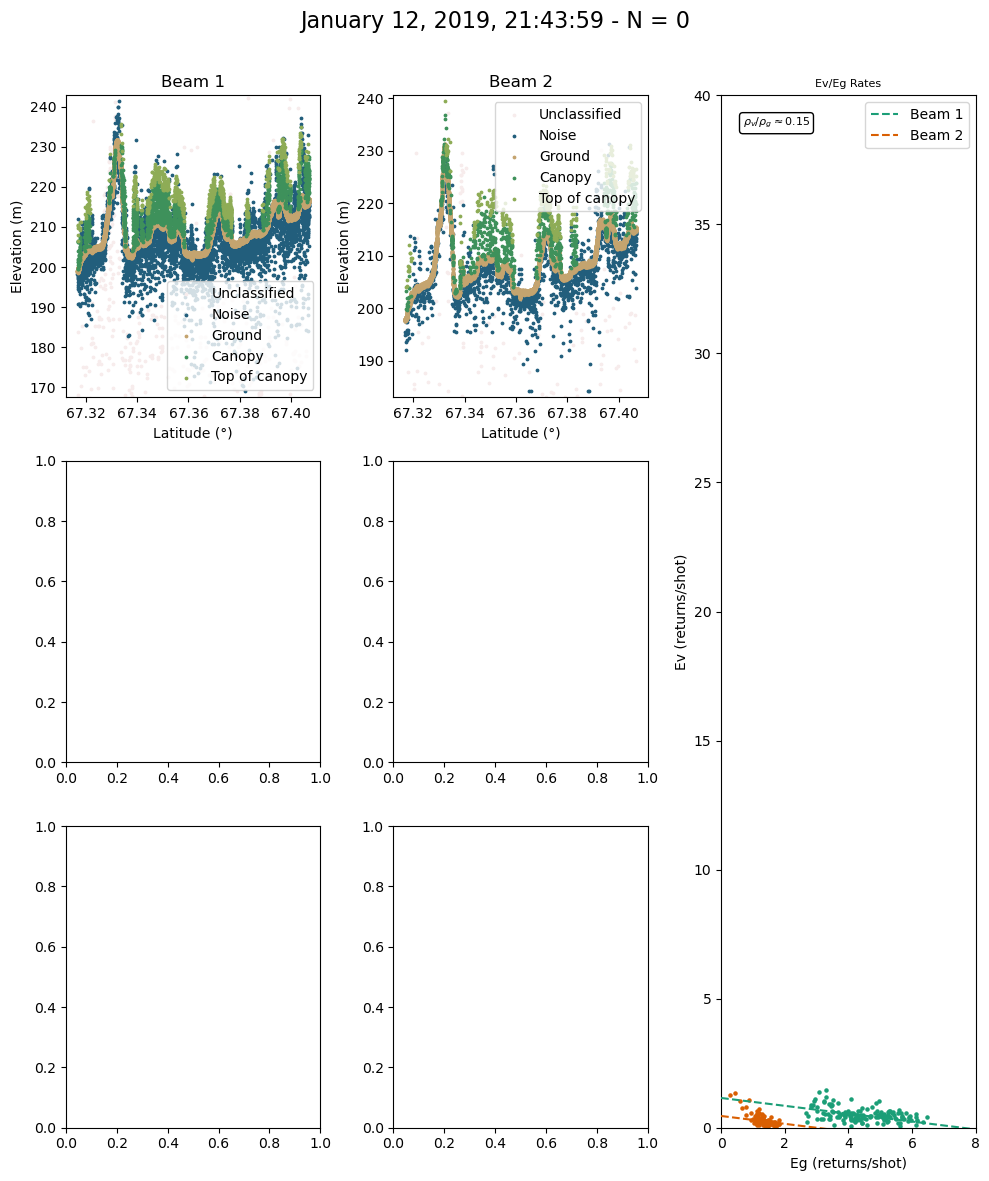

1
Nothing in rebinned section for sodankyla_full file 1's beam 1.
Nothing in rebinned section for sodankyla_full file 1's beam 2.


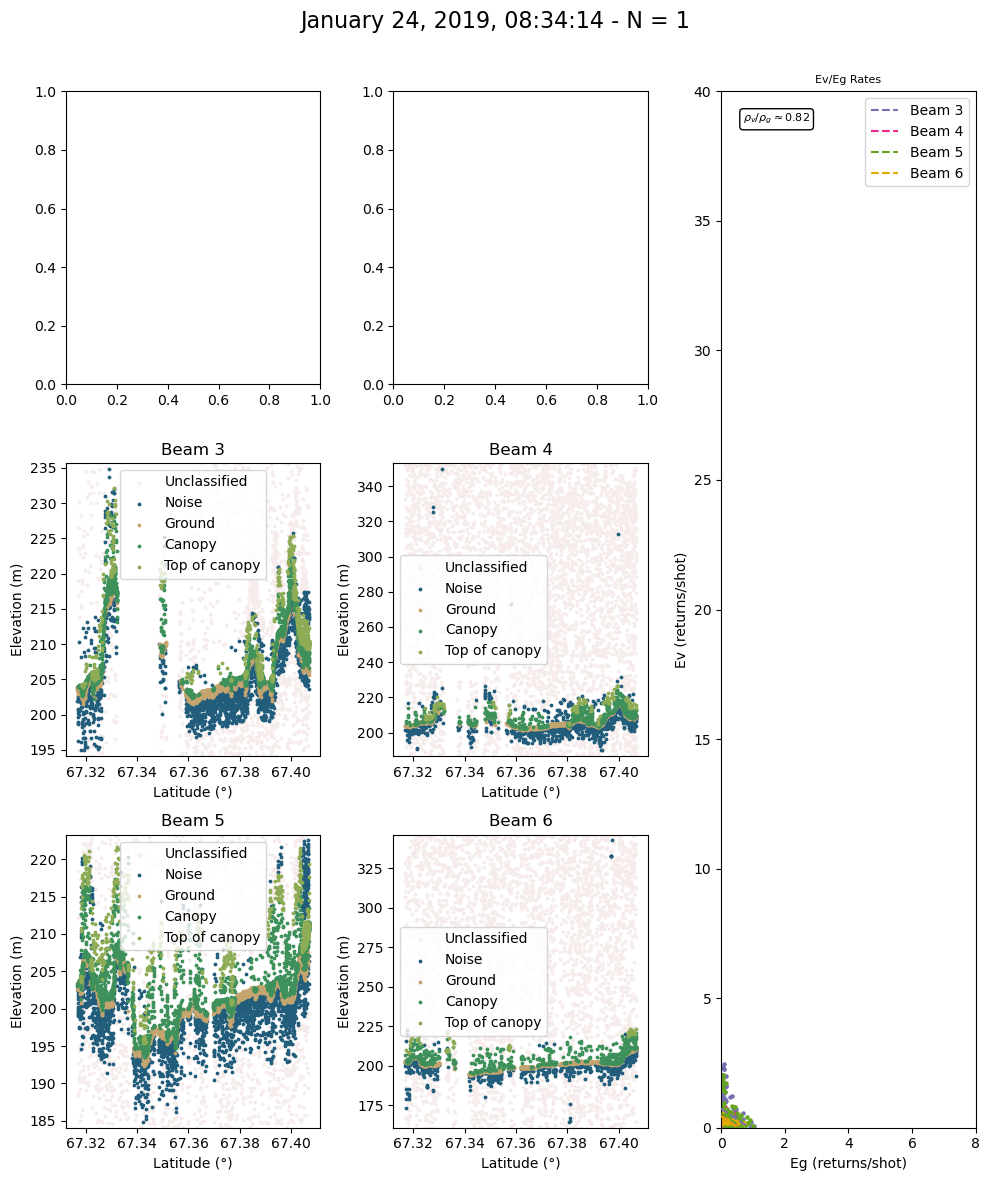

2
Nothing in rebinned section for sodankyla_full file 2's beam 2.
Nothing in rebinned section for sodankyla_full file 2's beam 3.
Nothing in rebinned section for sodankyla_full file 2's beam 4.
Nothing in rebinned section for sodankyla_full file 2's beam 5.
Nothing in rebinned section for sodankyla_full file 2's beam 6.


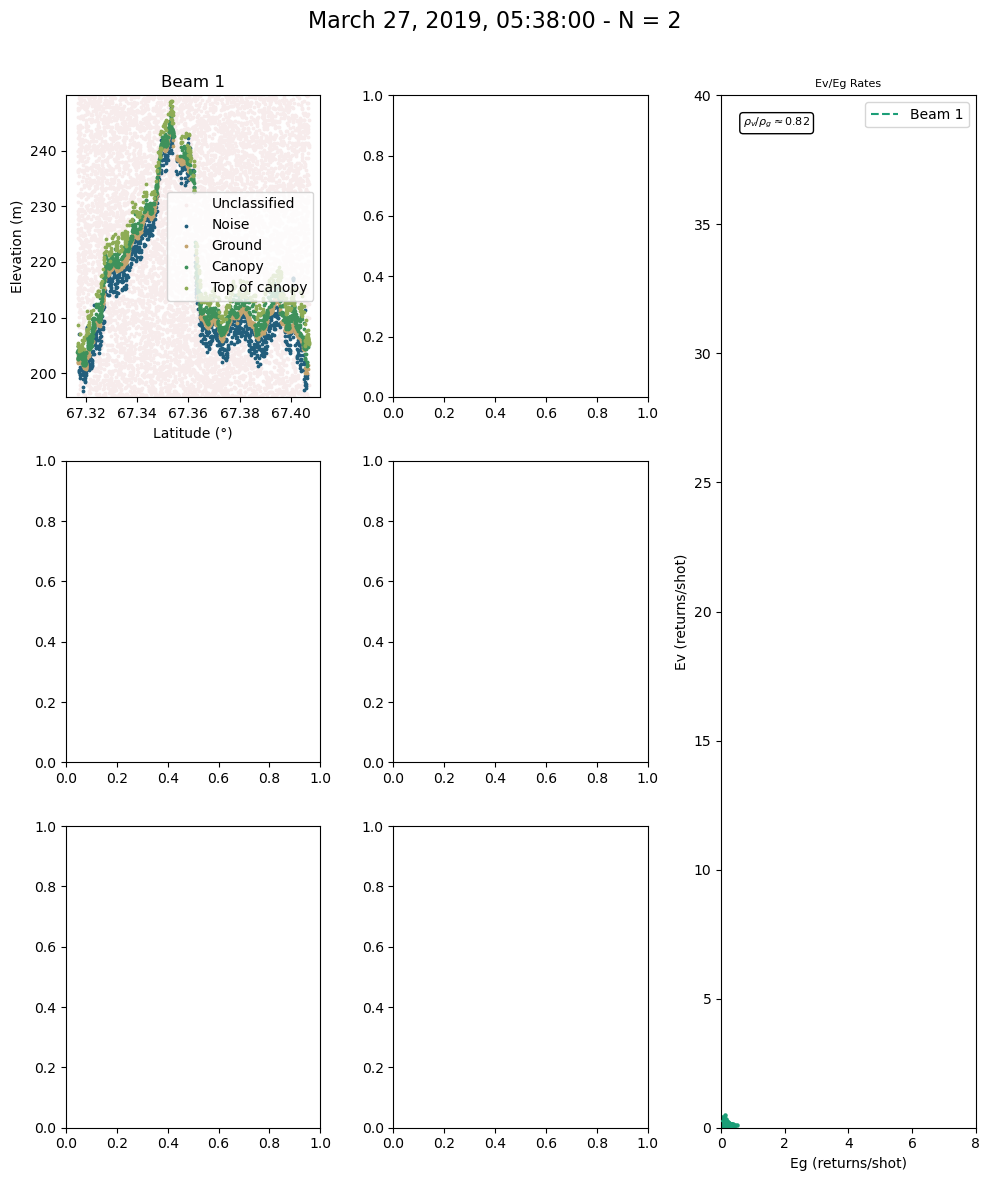

3
Nothing in rebinned section for sodankyla_full file 3's beam 5.
Nothing in rebinned section for sodankyla_full file 3's beam 6.


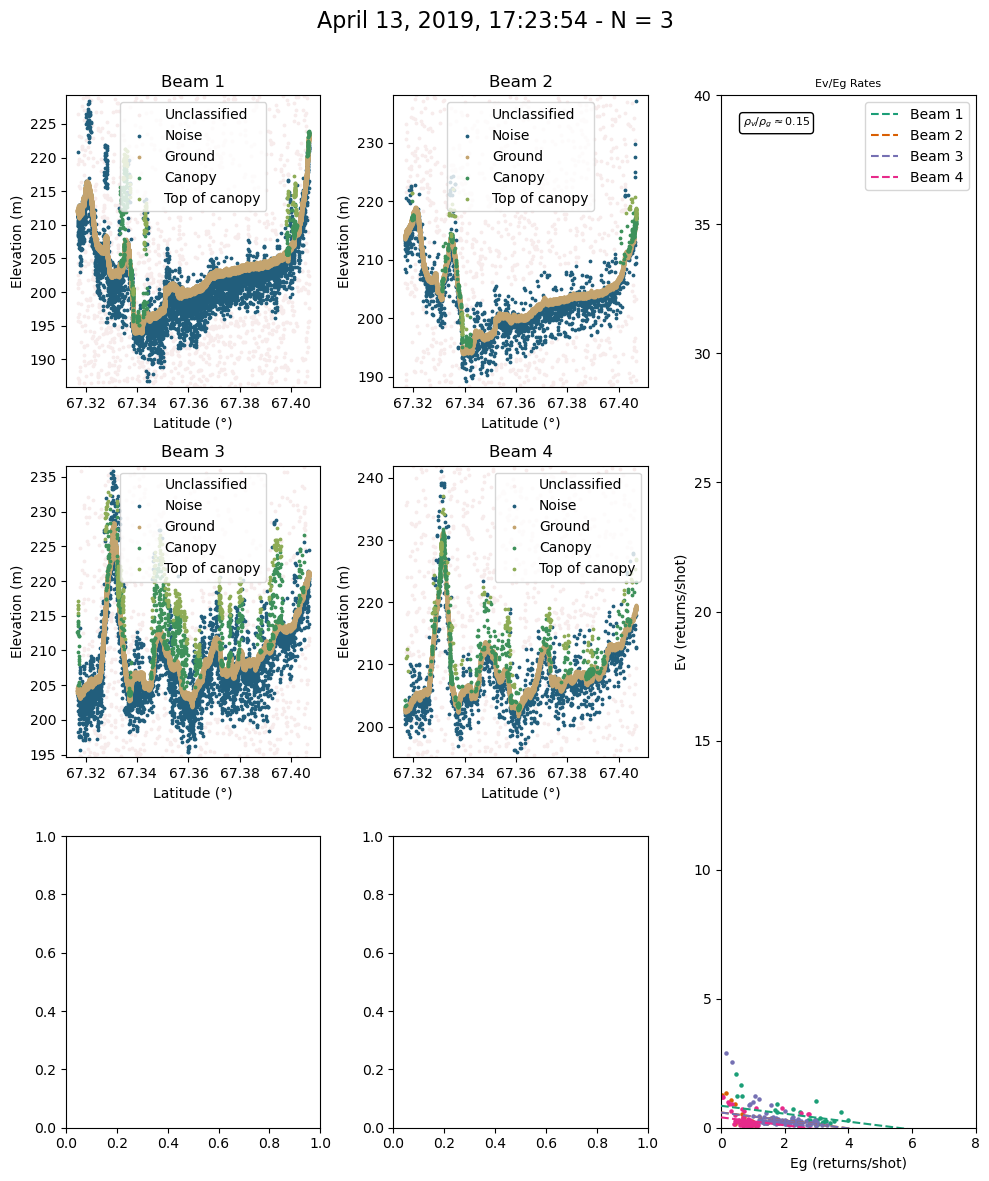

In [1]:
from scripts.parallel_blocks import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/sodankyla_full/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (26.634154, 67.361833)

for i in range(4):
# for i in [3,4,5,7,8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=185, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=185, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=185, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

# Delta Junction

Nothing in rebinned section for delta_junction file 0's beam 5.
Nothing in rebinned section for delta_junction file 0's beam 6.


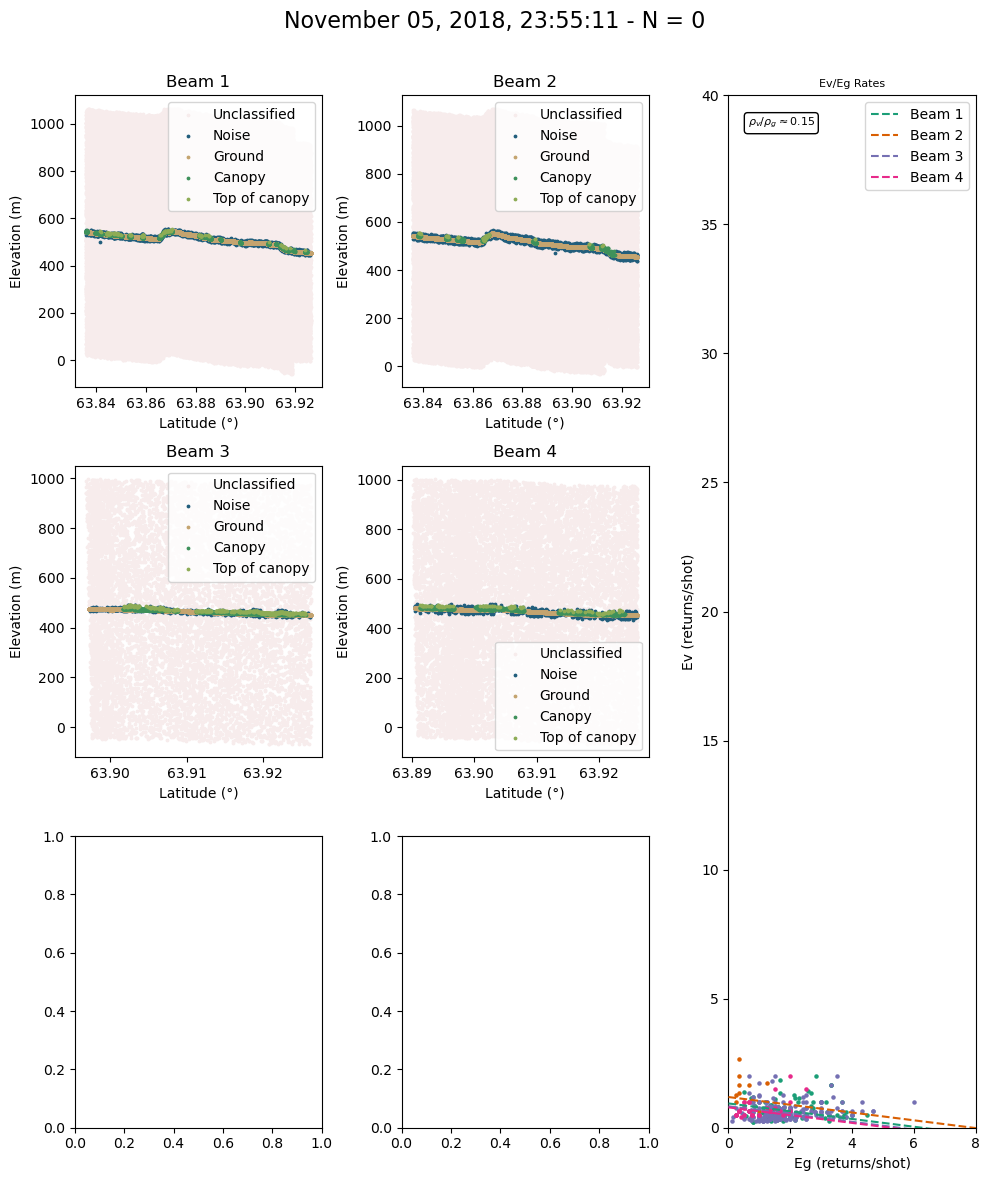

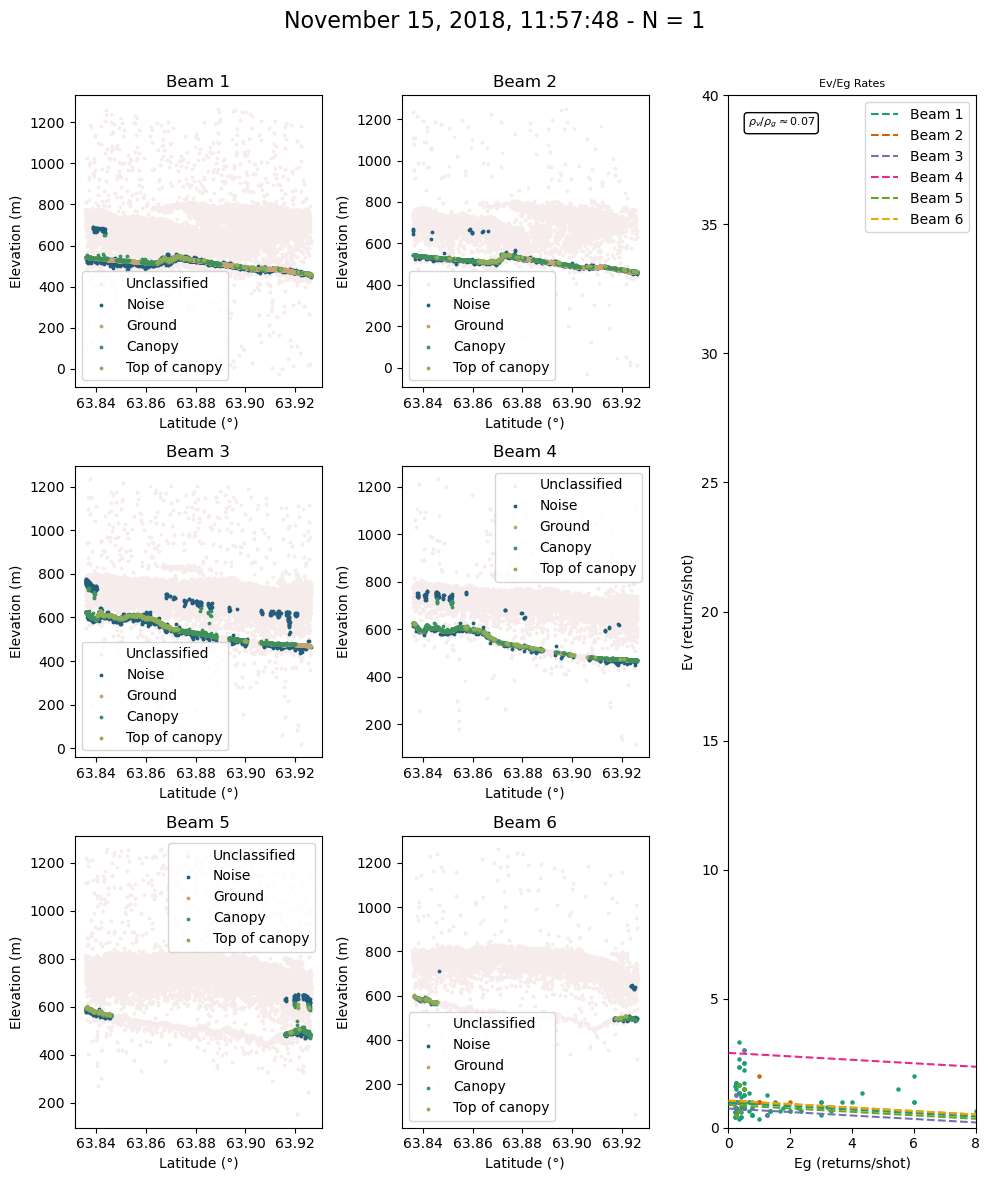

Nothing in rebinned section for delta_junction file 2's beam 1.
Nothing in rebinned section for delta_junction file 2's beam 2.


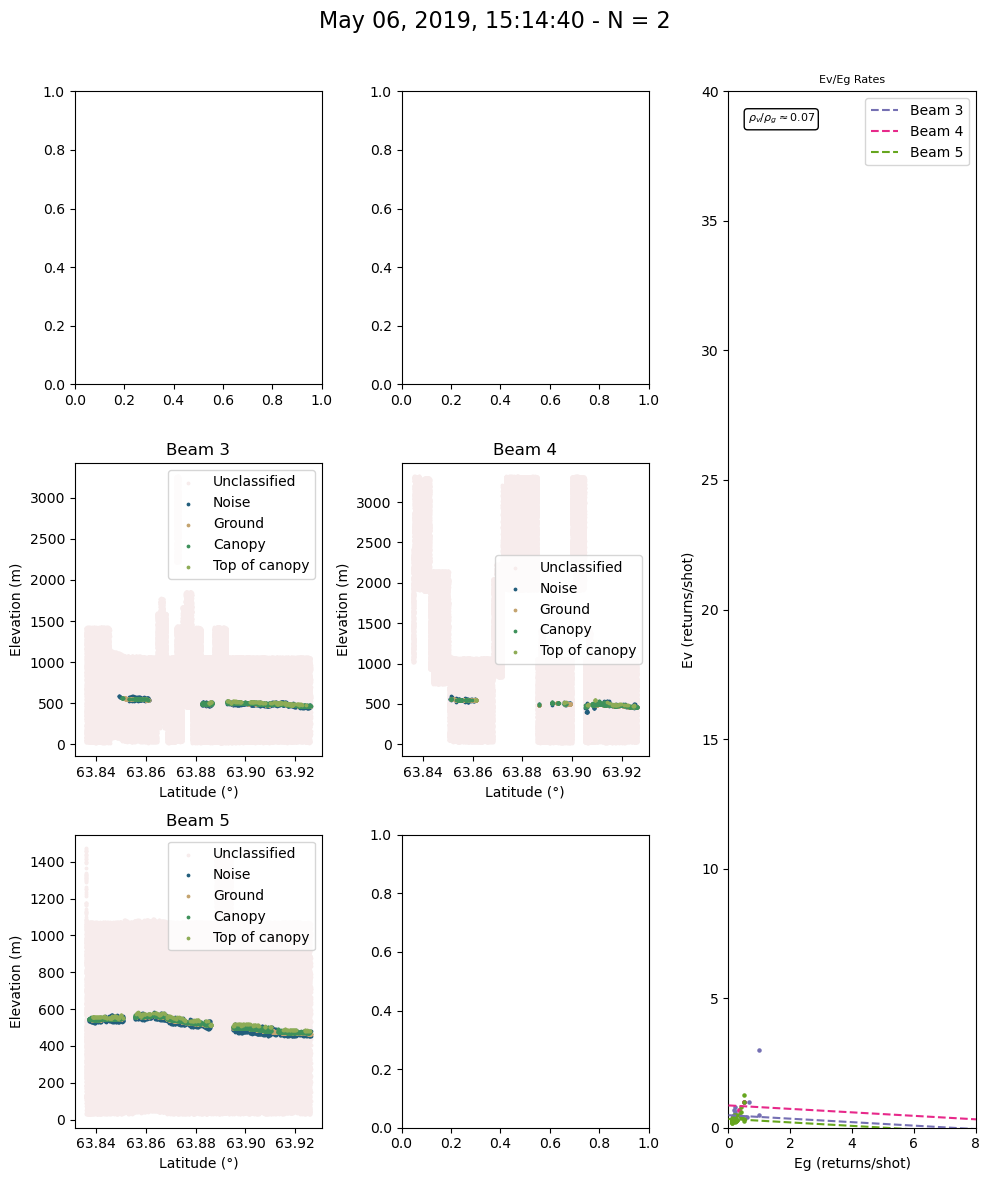

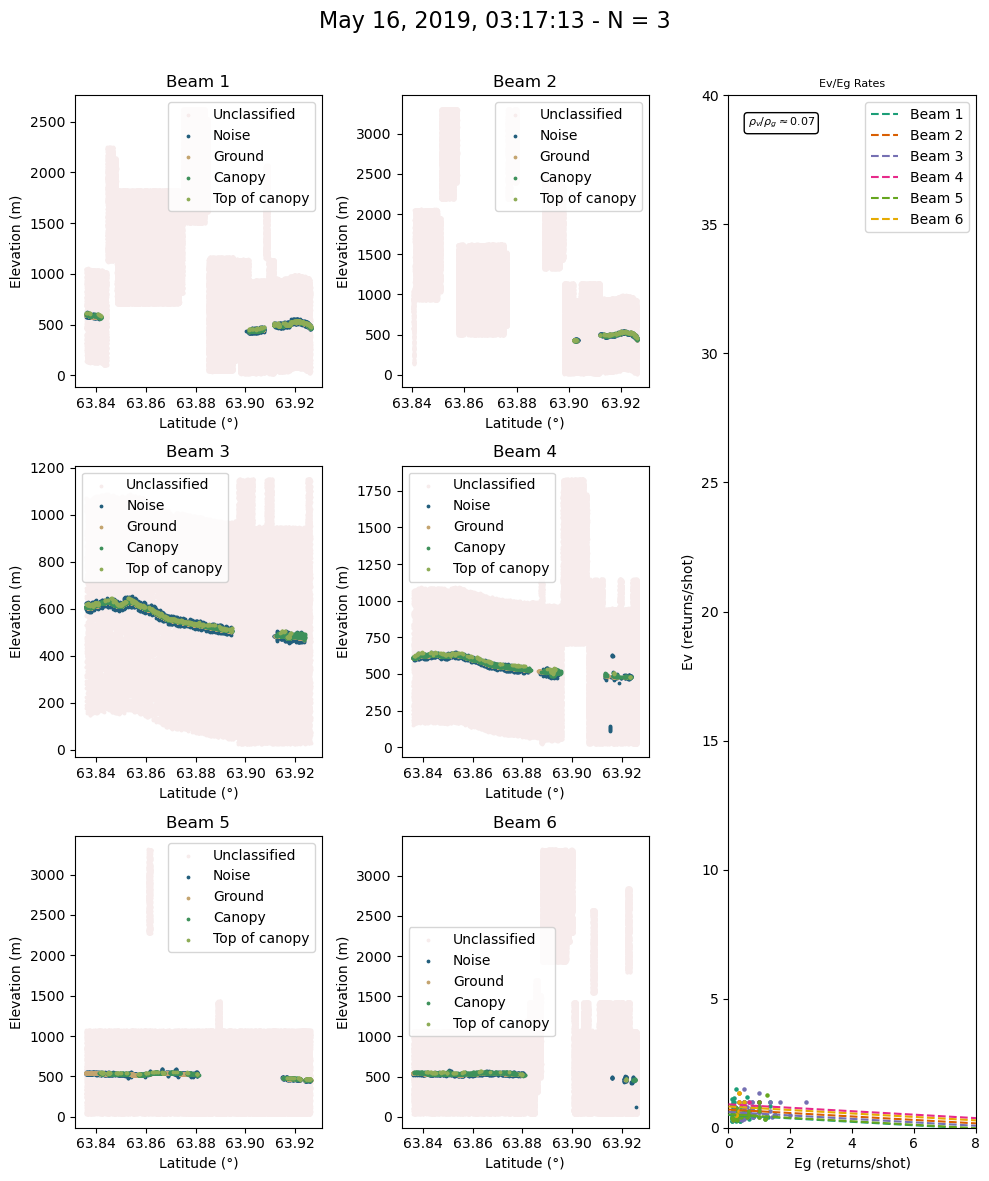

In [2]:
from scripts.parallel_blocks import *
# from scripts.parallel_phoreal import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/delta_junction/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-145.7514, 63.8811)

for i in range(4):
# for i in [3,4,5,7,8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=504, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=504, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=504, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

# Marcell MN

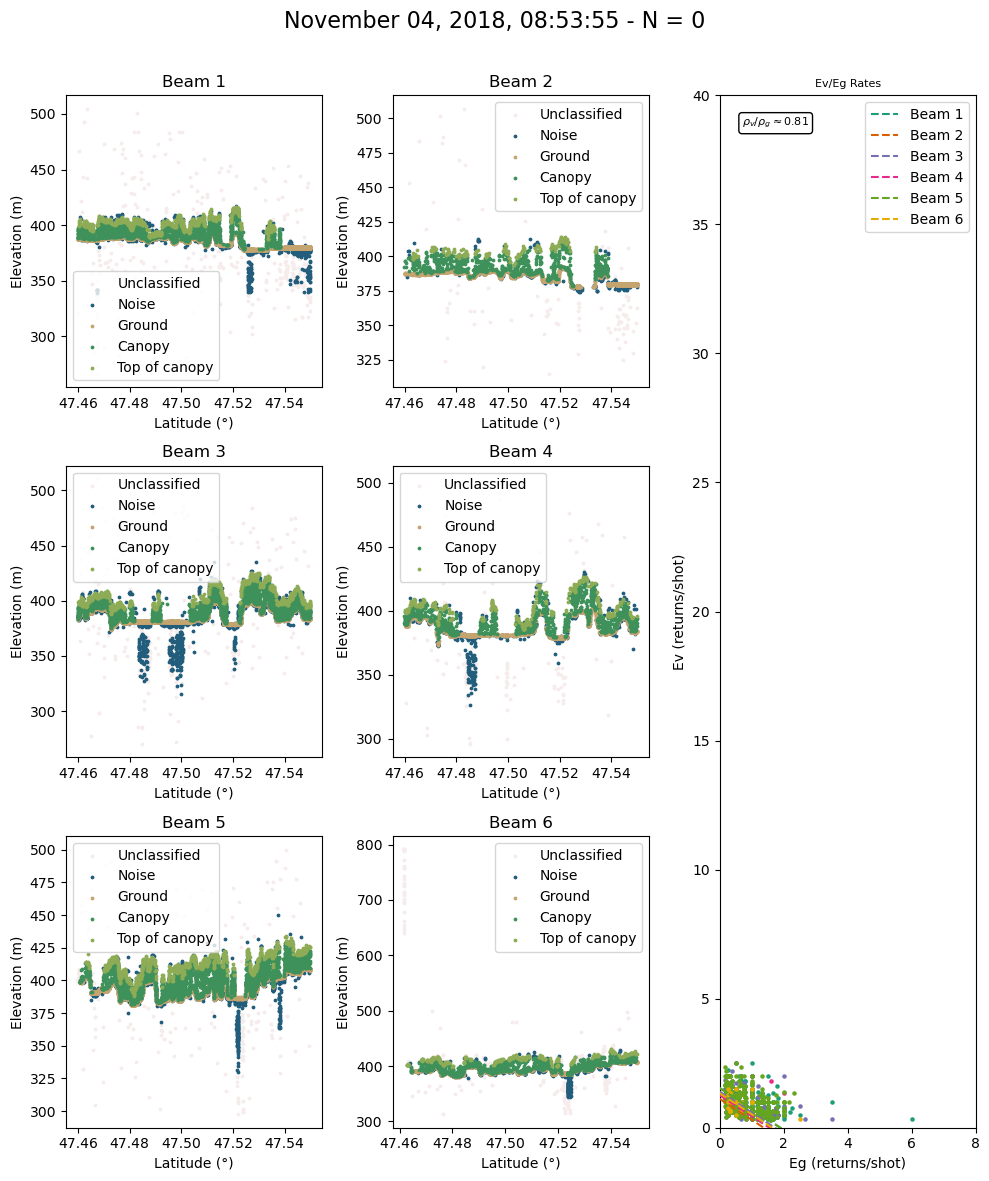

Nothing in rebinned section for marcell_MN file 1's beam 1.
Nothing in rebinned section for marcell_MN file 1's beam 2.


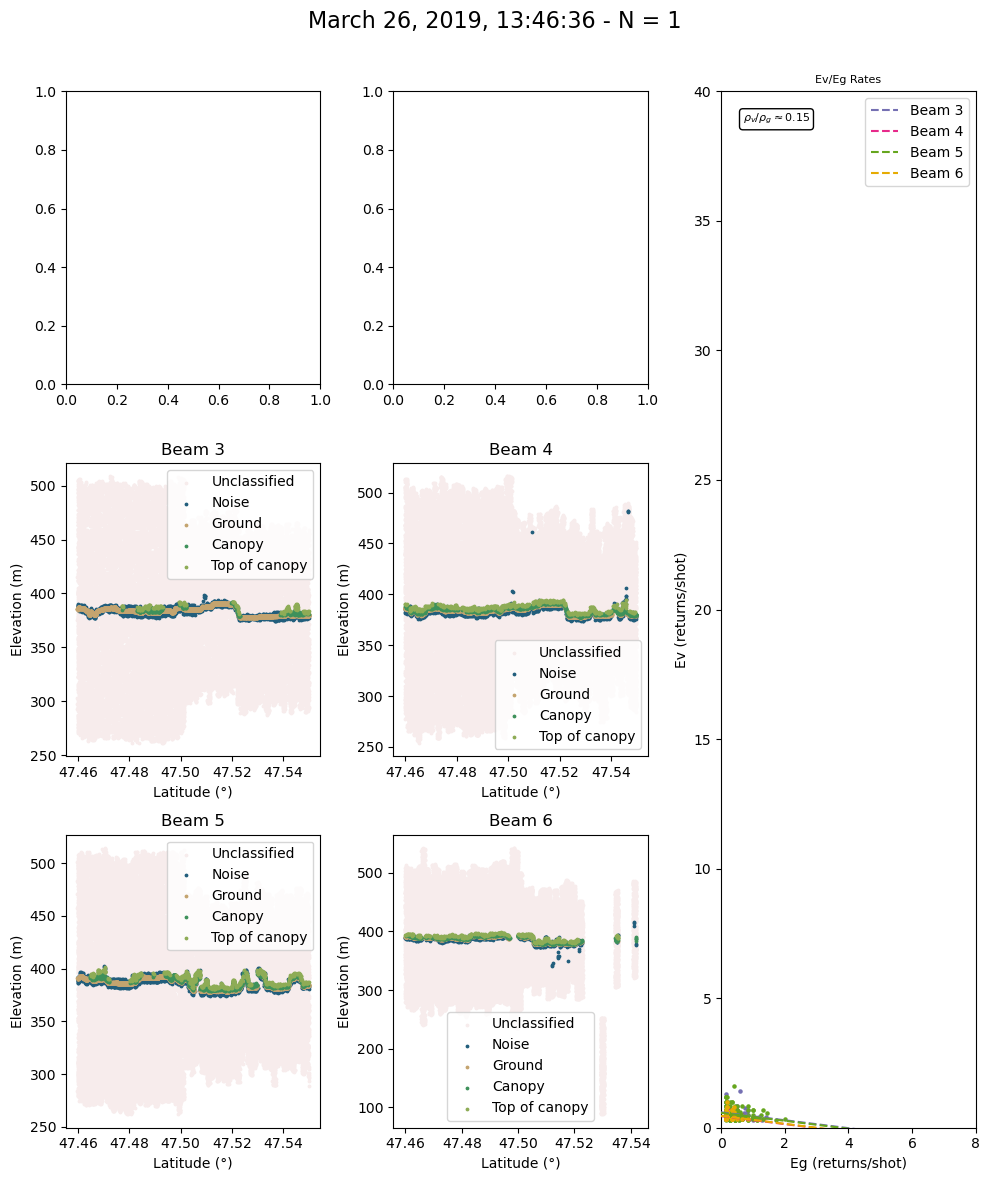

Nothing in rebinned section for marcell_MN file 2's beam 1.
Nothing in rebinned section for marcell_MN file 2's beam 2.


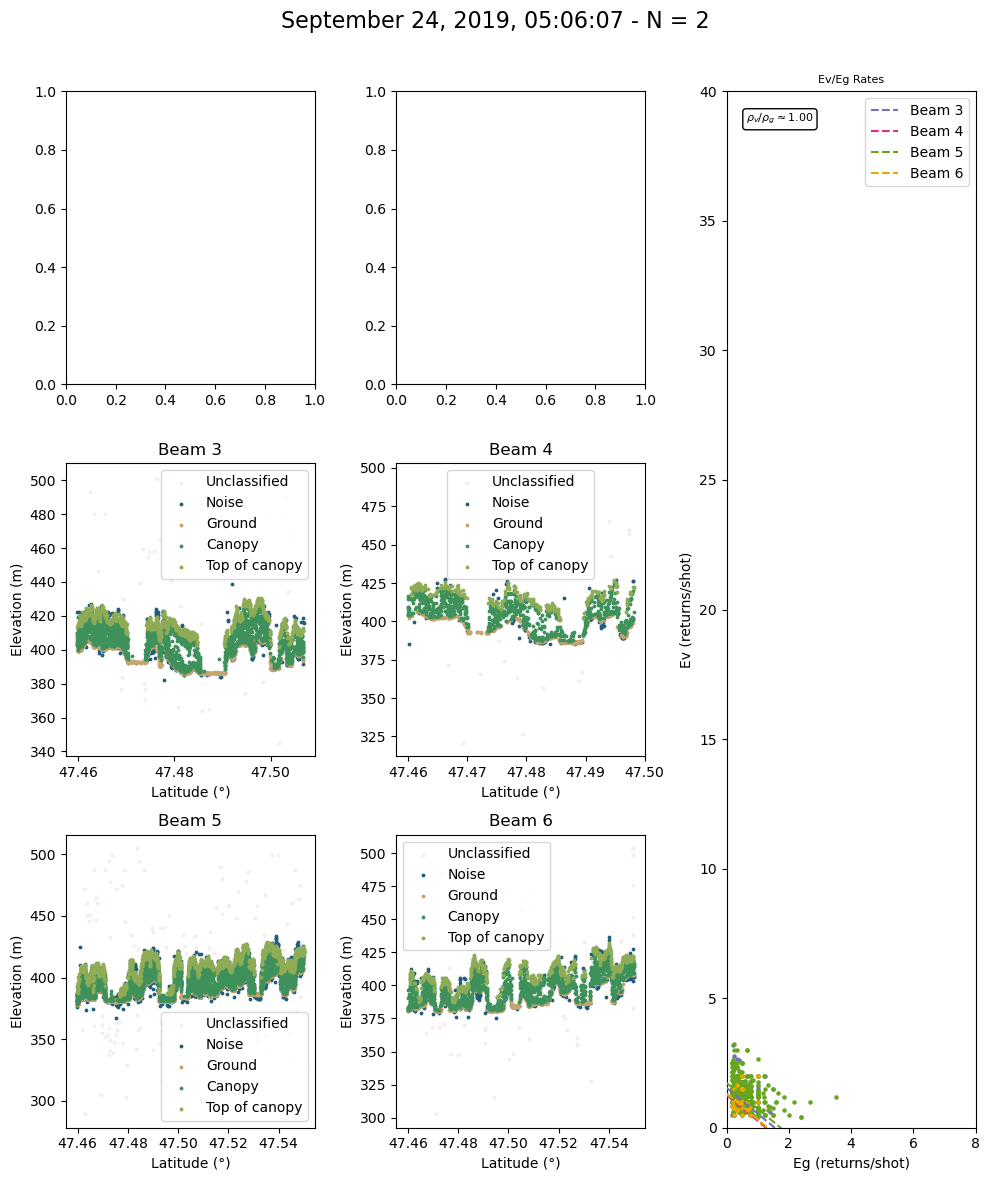

Nothing in rebinned section for marcell_MN file 3's beam 1.
Nothing in rebinned section for marcell_MN file 3's beam 2.


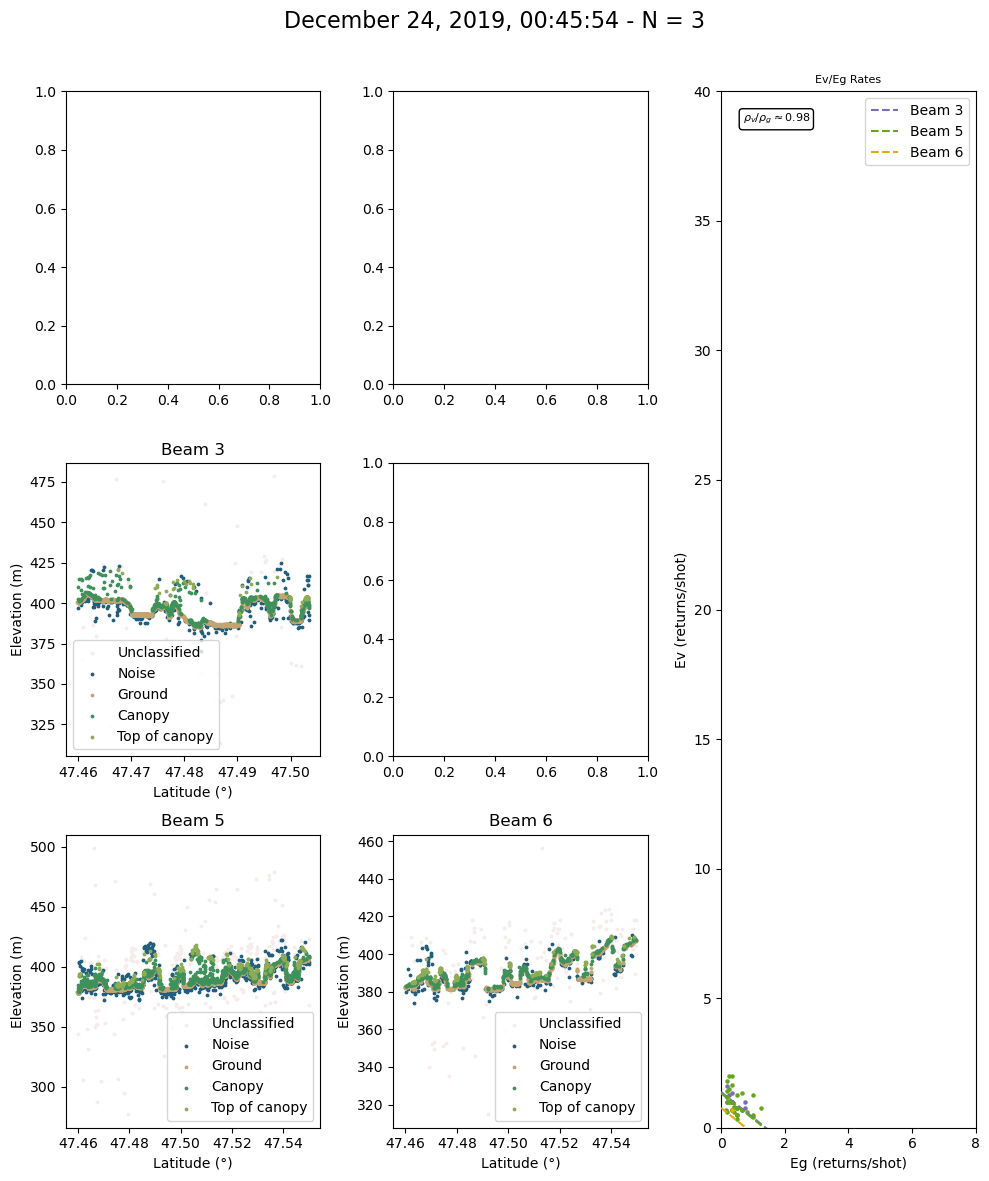

In [1]:
from scripts.parallel_blocks import *
# from scripts.parallel_phoreal import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/marcell_MN/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-93.4541, 47.5049)

for i in range(4):
# for i in [3,4,5,7,8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=413, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=413, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=413, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

# Lacclair

Nothing in rebinned section for lacclair file 0's beam 3.
Nothing in rebinned section for lacclair file 0's beam 4.
Nothing in rebinned section for lacclair file 0's beam 5.
Nothing in rebinned section for lacclair file 0's beam 6.


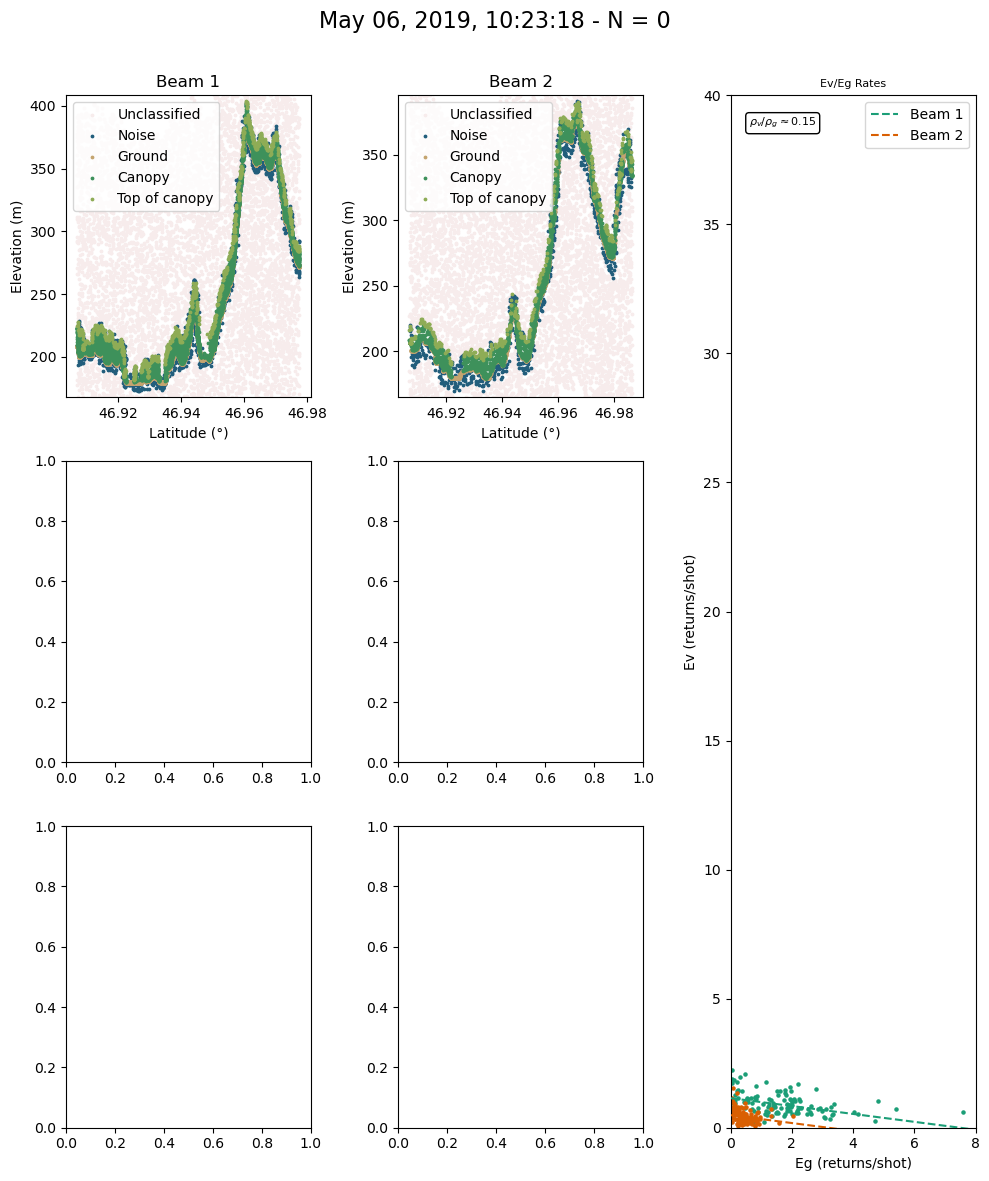

Nothing in rebinned section for lacclair file 1's beam 6.


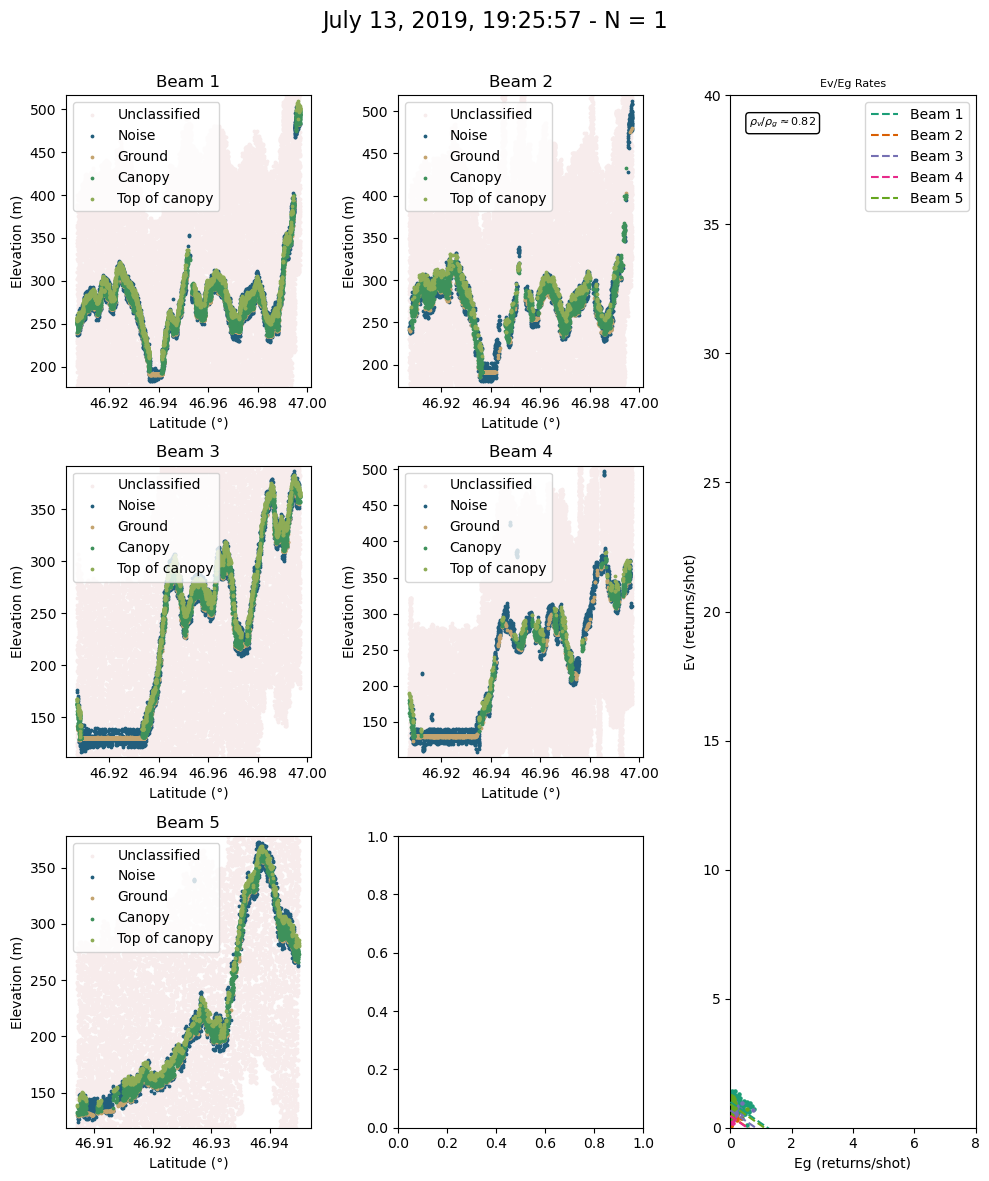

Nothing in rebinned section for lacclair file 2's beam 5.
Nothing in rebinned section for lacclair file 2's beam 6.


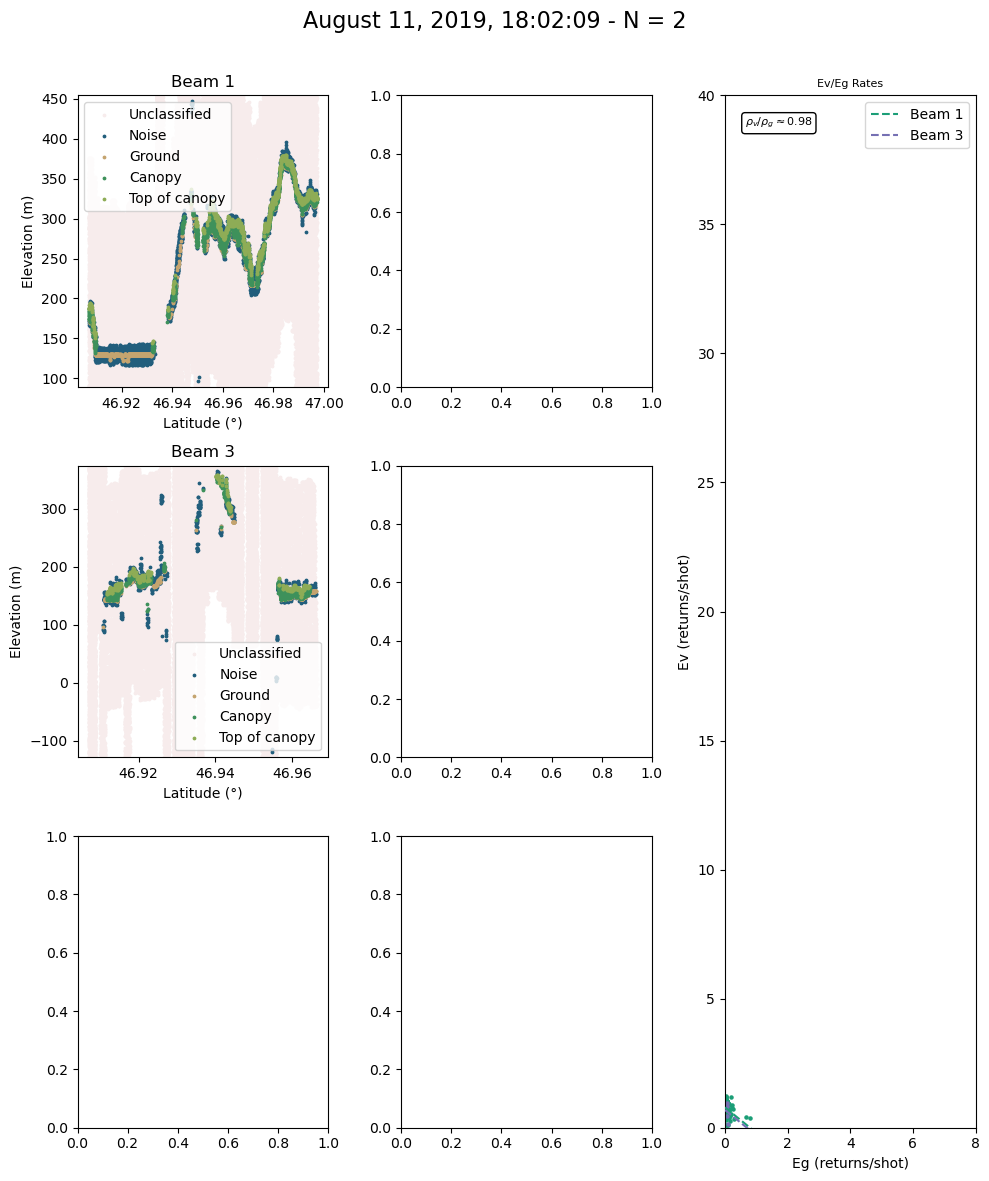

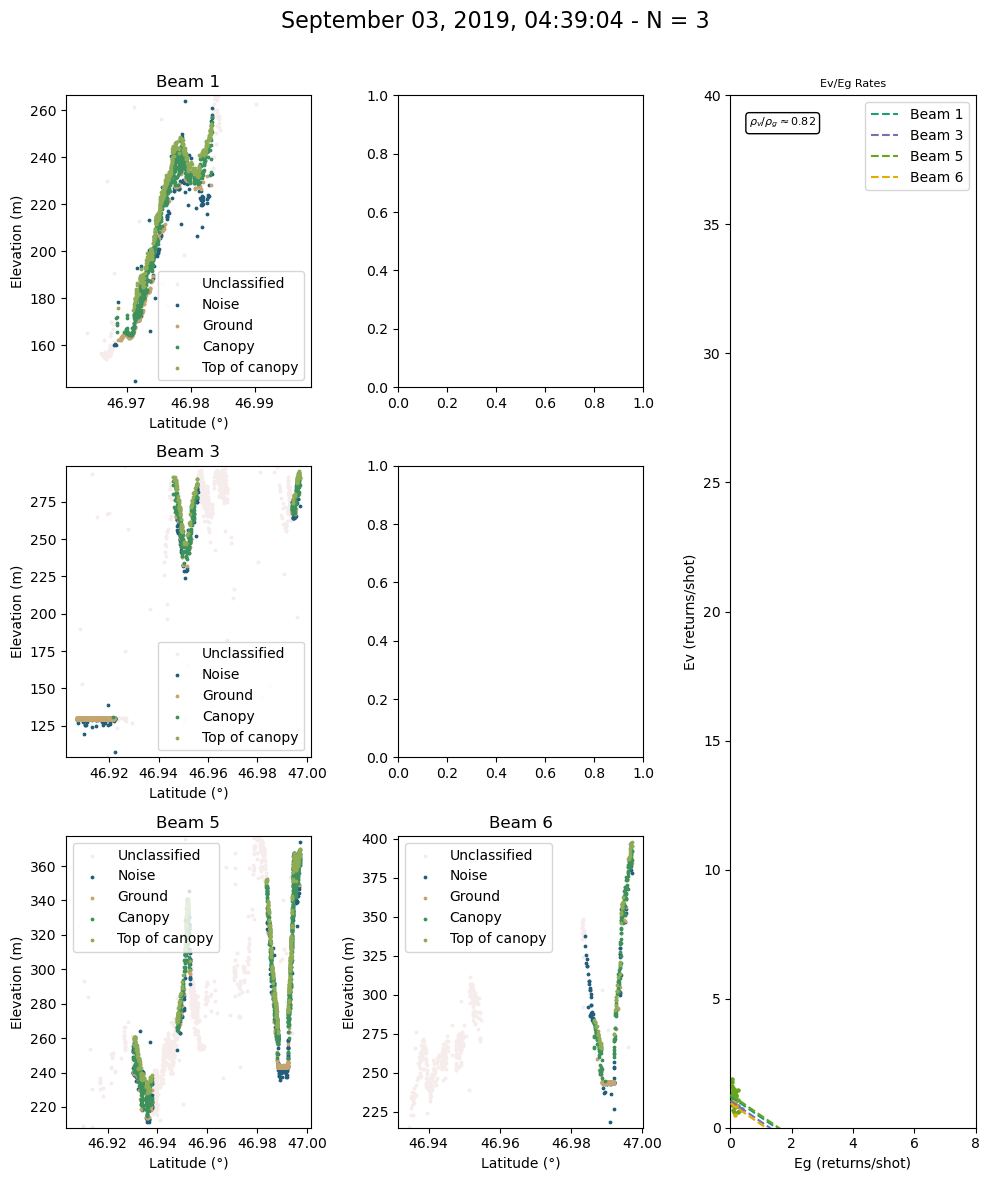

In [1]:
from scripts.parallel_blocks import *
# from scripts.parallel_phoreal import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/lacclair/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-71.6696, 46.9521)

for i in range(4):
# for i in [3,4,5,7,8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=313, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=313, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=313, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

# Torgnon

Nothing in rebinned section for torgnon file 8's beam 3.
Nothing in rebinned section for torgnon file 8's beam 4.
Nothing in rebinned section for torgnon file 8's beam 5.
Nothing in rebinned section for torgnon file 8's beam 6.


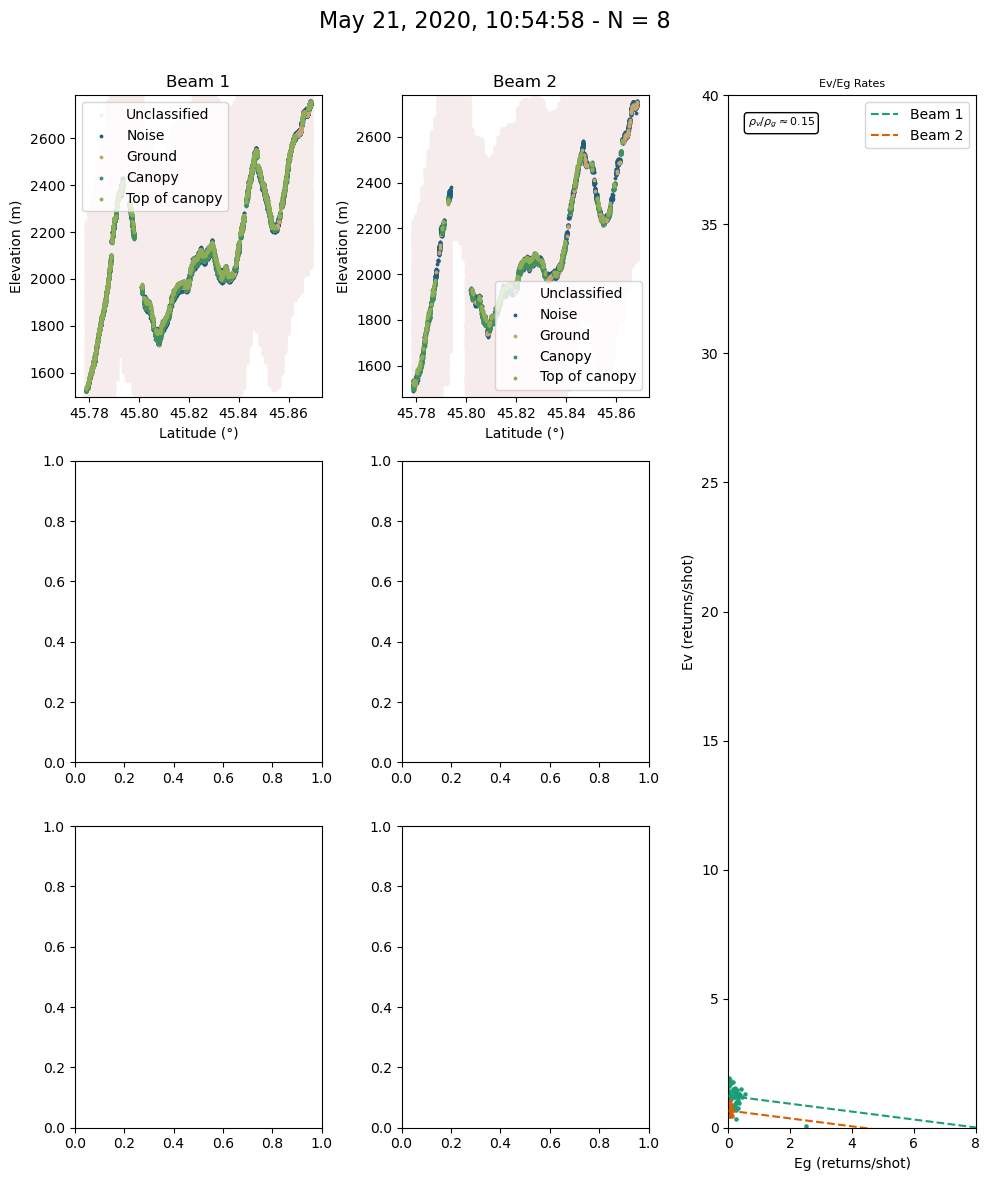

In [1]:
from scripts.parallel_blocks import *
# from scripts.parallel_phoreal import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/torgnon/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (7.5609, 45.8238)

for i in [8]:
# for i in [3,4,5,7,8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=2091, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=2091, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=2091, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

In [3]:
data

camera        date     lon      lat  pvpg_regressed  pv_regressed  \
0   torgnon  21/05/2020  7.5609  45.8238         0.15315      1.206580   
1   torgnon  21/05/2020  7.5609  45.8238         0.15315      1.206580   
2   torgnon  21/05/2020  7.5609  45.8238         0.15315      1.206580   
3   torgnon  21/05/2020  7.5609  45.8238         0.15315      1.206580   
4   torgnon  21/05/2020  7.5609  45.8238         0.15315      1.206580   
..      ...         ...     ...      ...             ...           ...   
77  torgnon  21/05/2020  7.5609  45.8238         0.15315      0.672116   
78  torgnon  21/05/2020  7.5609  45.8238         0.15315      0.672116   
79  torgnon  21/05/2020  7.5609  45.8238         0.15315      0.672116   
80  torgnon  21/05/2020  7.5609  45.8238         0.15315      0.672116   
81  torgnon  21/05/2020  7.5609  45.8238         0.15315      0.672116   

    pg_regressed        Eg        Ev  data_quantity  ...       asr  \
0       7.878434  0.260870  1.282609             56  ...  0.047527   
1       7.878434  0.404255  1.489362             56  ...  0.047527   
2       7.878434  0.229167  1.000000             56  ...  0.047527   
3       7.878434  0.148936  0.702128             56  ...  0.044648   
4       7.878434  0.020833  1.812500             56  ...  0.101573   
..           ...       ...       ...            ...  ...       ...   
77      4.388617  0.022727  0.659091             26  ...  0.035802   
78      4.388617  0.022222  0.888889             26  ...  0.072330   
79      4.388617  0.045455  0.545455             26  ...  0.108859   
80      4.388617  0.022222  0.600000             26  ...  0.145388   
81      4.388617  0.022727  0.795455             26  ...  0.181916   

    canopy_openness       snr  segment_cover  segment_landcover  h_te_interp  \
0          3.162023  0.109752           24.0               30.0  2023.194336   
1          1.832500  0.109752           25.0               30.0  2043.570923   
2          2.874270  0.109752           25.0               30.0  2063.947510   
3          5.154565  0.109752           25.0               30.0  2099.118083   
4          7.280330  0.109752           33.0               30.0  2020.780884   
..              ...       ...            ...                ...          ...   
77         7.746795  0.037733           14.0               30.0  2047.228271   
78         7.285808  0.037733           14.0               30.0  2059.134766   
79         6.299254  0.037733           14.0               30.0  2071.041260   
80         5.894929  0.037733           36.0               30.0  2082.947754   
81         6.680156  0.037733           36.0               30.0  2094.854248   

    h_te_std  terrain_slope  longitude   latitude  
0   4.934567       1.029974   7.524243  45.788046  
1   6.605096       0.814527   7.524212  45.788270  
2   3.704525       1.094736   7.524181  45.788494  
3   6.324092       1.362513   7.524140  45.788794  
4   0.000000            NaN   7.519745  45.820801  
..       ...            ...        ...        ...  
77  0.000000            NaN   7.518532  45.838287  
78  0.000000            NaN   7.518503  45.838511  
79  0.056396       0.077149   7.518474  45.838736  
80  0.000000            NaN   7.518445  45.838960  
81  0.000000            NaN   7.518416  45.839184  

[82 rows x 25 columns]

# Oregon Young Pine

../data_store/data/oregon_yp/ 8
1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3


/home/s1803229/src/PhoREAL/phoreal/binner.py:651: FutureWarning: The provided callable <function max at 0x78a687cfbec0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  sub_bin = zgroup.aggregate(np.max) #LARAIA


1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3


/home/s1803229/src/PhoREAL/phoreal/binner.py:651: FutureWarning: The provided callable <function max at 0x78a687cfbec0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  sub_bin = zgroup.aggregate(np.max) #LARAIA


1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3


/home/s1803229/src/PhoREAL/phoreal/binner.py:651: FutureWarning: The provided callable <function max at 0x78a687cfbec0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  sub_bin = zgroup.aggregate(np.max) #LARAIA


1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3


/home/s1803229/src/PhoREAL/phoreal/binner.py:651: FutureWarning: The provided callable <function max at 0x78a687cfbec0> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  sub_bin = zgroup.aggregate(np.max) #LARAIA


1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3
Nothing in rebinned section for oregon_yp file 8's beam 5.
1
a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
A5
h
i
j
k
l
m
n
o
p
q
2
A2
A2
A5
A5
A5
3
Nothing in rebinned section for oregon_yp file 8's beam 6.


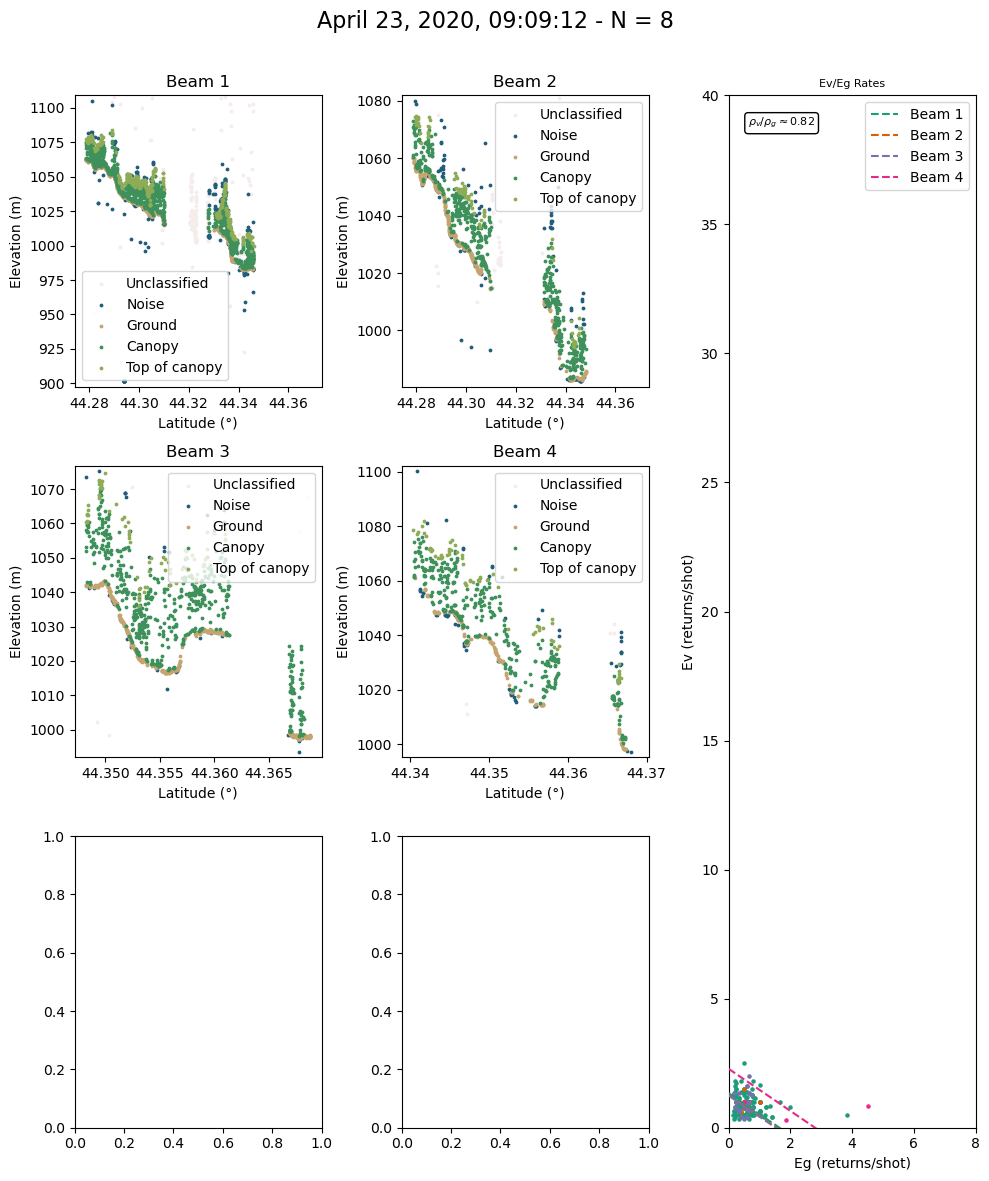

In [1]:
from scripts.parallel_blocks import *
# from scripts.parallel_phoreal import *
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Adjust the display width to show all columns
# pd.set_option('display.max_colwidth', None)  # Show full content of each column

dirpath = '../data_store/data/oregon_yp/'

all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
N = len(all_ATL03)

coords = (-121.606, 44.3238)

# for i in range(4):
for i in [8]:
    # print(all_ATL03[i], all_ATL08[i])

    # BASE
    # data = pvpg_parallel(all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=977, threshold=1, graph_detail=1)

    # BLOCKS
    data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
                         altitude=977, threshold=1, small_box=10, graph_detail=2, loss='linear', rebinned=30, f_scale=.05,\
                         outlier_removal=2,method='bimodal')
    # data = pvpg_parallel(dirpath, all_ATL03[i], all_ATL08[i], coords=coords, width=5,height=5,file_index=i, alt_thresh=80,\
    #                      altitude=977, threshold=1, small_box=10, graph_detail=1, loss='arctan', rebinned=30, f_scale=.05,
    #                      outlier_removal=3)

In [ ]:
# from scripts.track_pairs import *
import sys

sys.path.insert(1,'/home/s1803229/src/PhoREAL')

from phoreal.reader import get_atl03_struct, get_atl08_struct
from phoreal.binner import rebin_atl08

# dirpath = '../data_store/data/oregon_yp/'

ATL03_dirpath = '../data_store/data/oregon_yp/ATL03_20200617181343_12710702_006_01.h5'
ATL08_dirpath = '../data_store/data/oregon_yp/ATL08_20200617181343_12710702_006_01.h5'

# all_ATL03, all_ATL08, failed_ATL03 = track_pairs(dirpath, failed=True)
# ATL03_dirpath = all_ATL03[9]
# ATL08_dirpath = all_ATL08[9]

# print(ATL03_dirpath)
# print(ATL08_dirpath)

# gts = ['gt3l', 'gt3r', 'gt2l', 'gt2r', 'gt1l', 'gt1r']

atl03 = get_atl03_struct(ATL03_dirpath, 'gt3l', ATL08_dirpath)

a
b
c
d
e
f
g
A1
A1
A4
A4
A5
A5
